<a href="https://colab.research.google.com/github/Collin-Campbell/DS-Unit-1-Sprint-3-Linear-Algebra/blob/master/module4-clustering/LS_DS_134_Clustering_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-Means Clustering

# 1) Use the "Breast Cancer Wisconsin (Diagnostic) Data Set" from Kaggle to try and cluster types of cancer cells. 

Here's the original dataset for your reference:

<https://www.kaggle.com/uciml/breast-cancer-wisconsin-data>

## This is a supervised learning dataset

(Because it has **labels** - The "diagnosis" column.)

In [519]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA # You don't necessarily have to use this
from sklearn.cluster import KMeans # You don't necessarily have to use this
from sklearn.preprocessing import StandardScaler # You don't necessarily have to use this

df = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/Cancer_Cells.csv")
print(df.shape)
df.head()

(569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Now it's an unsupervised learning dataset

(Because we've removed the diagnosis label) - Use this version.

In [520]:
# Saving before I drop for later testing

df_diagnosis_test = df['diagnosis']

In [521]:
df_diagnosis_test.value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

In [522]:
df_diagnosis_test = pd.DataFrame(df_diagnosis_test)
df_diagnosis_test = df_diagnosis_test.replace({'M': 1, 'B': 0})

In [523]:
df_diagnosis_test

,diagnosis
0,1
1,1
2,1
3,1
4,1
...,...
564,1
565,1
566,1
567,1


In [524]:
df = df.drop(['id','diagnosis', 'Unnamed: 32'], axis=1)

# Dropped diagnosis to make unsupervised, dropped Unnamed due to NaNs, dropped id because unneeded

In [525]:
print(df.shape)
df.head()

(569, 30)


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [526]:
df.dtypes

radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst            float64
concave points_worst       float64
symmetry_worst      

In [527]:
df.isnull().sum()

radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

## Let's do it!

- You might want to do some data exploration to see if you can find specific columns that will help you find distinct clusters of cells
- You might want to use the elbow method to decide on the number of clusters to use.


In [528]:
# Perform K-Means Clustering on the Dataset

# Would begin by importing KMeans:
from sklearn.cluster import KMeans

# Find elbow
K = range(1,11)
sum_squared_distance = []

for k in K:
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(df)
  sum_squared_distance.append(kmeans.inertia_)

sum_squared_distance

[256677243.9542025,
 77943099.87829883,
 47336610.421990566,
 29226541.651979793,
 20539877.62210288,
 16562261.629261008,
 13265633.471255187,
 11200895.217108302,
 9563489.99331559,
 8400070.389167644]

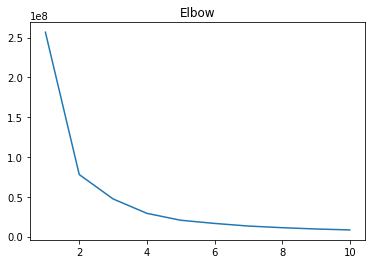

In [529]:
plt.plot(K, sum_squared_distance)

plt.title('Elbow')

plt.show()

In [530]:
# instantiate the sklearn class and pick a number of clusters (2 based on elbow plot)
kmeans = KMeans(n_clusters=2)

# fit the instantiate model to our data
kmeans.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [531]:
# create the labels
labels = kmeans.labels_
print(labels)

[1 1 1 0 1 0 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0
 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0
 0 1 0 1 1 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0 0
 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 1 1 0 1 0 1
 0 1 1 1 0 1 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0
 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1
 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0
 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 1 1 

In [532]:
# add new labels to the dataframe as a clusters column
df_diagnosis_test['clusters'] = labels
df_diagnosis_test.head()

,diagnosis,clusters
0,1,1
1,1,1
2,1,1
3,1,0
4,1,1


## Check you work: 

This is something that in a truly unsupervised learning situation **WOULD NOT BE POSSIBLE**. But for educational purposes go back and grab the true diagnosis column (label) from the original dataset. Take your cluster labels and compare them to the original diagnosis column. You can make scatterplots for each to see how they compare or you can calculate a percent accuracy score like: 
\begin{align}
\frac{\text{Num Correct Labels}}{\text{Num Total Observations}}
\end{align}

In [533]:
test = (df_diagnosis_test["diagnosis"] == df_diagnosis_test["clusters"])
test

0       True
1       True
2       True
3      False
4       True
       ...  
564     True
565     True
566    False
567     True
568     True
Length: 569, dtype: bool

In [534]:
((test == True).sum() / test.value_counts().sum()) * 100

85.41300527240774

In [535]:
# 85% accuracy on raw data

# 2) Perform PCA on your dataset first and *then* use k-means clustering. 

- You need to standardize your data before PCA.
- First try clustering just on PC1 and PC2 so that you can make a scatterplot of your clustering.
- Then use use a scree plot to decide how many principal components to include in your clustering, and use however many principal components you need in order to retain 90% of the variation of the original dataset



In [536]:
# Make copy of cleaned dataframe

df_processed = df.copy()

In [537]:
# instantiate the SKLearn class for standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [538]:
# Standardize the dataset
df_processed = scaler.fit_transform(df_processed)

print(df_processed.mean())
print(df_processed.std())

# yes, the mean is zero and the std is 1, so our data is indeed scaled

1.2487570048507913e-18
1.0


In [539]:
# import and instantiate the PCA class
from sklearn.decomposition import PCA
pca = PCA(n_components=30)

In [540]:
# Apply PCA to the data
pca_features = pca.fit_transform(df_processed)

In [541]:
# how much variation did each principal component explain?
pca.explained_variance_ratio_

array([4.42720256e-01, 1.89711820e-01, 9.39316326e-02, 6.60213492e-02,
       5.49576849e-02, 4.02452204e-02, 2.25073371e-02, 1.58872380e-02,
       1.38964937e-02, 1.16897819e-02, 9.79718988e-03, 8.70537901e-03,
       8.04524987e-03, 5.23365745e-03, 3.13783217e-03, 2.66209337e-03,
       1.97996793e-03, 1.75395945e-03, 1.64925306e-03, 1.03864675e-03,
       9.99096464e-04, 9.14646751e-04, 8.11361259e-04, 6.01833567e-04,
       5.16042379e-04, 2.72587995e-04, 2.30015463e-04, 5.29779290e-05,
       2.49601032e-05, 4.43482743e-06])

In [542]:
# how much total variance did we explain?
sum(pca.explained_variance_ratio_)

1.0000000000000002

In [543]:
# how much information did we lose?
1 - sum(pca.explained_variance_ratio_)

-2.220446049250313e-16

In [317]:
### Make a scree plot

In [544]:
# define the number of components
num_components = len(pca.explained_variance_ratio_)
num_components

30

In [545]:
# create a numpy array as long as the number of components
ind = np.arange(num_components)
ind

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [546]:
# create an array of that amount of values
vals = pca.explained_variance_ratio_

<BarContainer object of 30 artists>

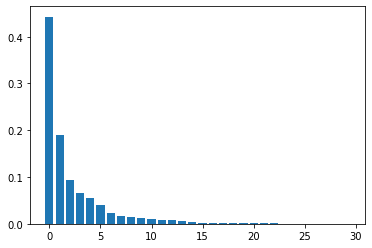

In [547]:
# Plot the variance explained by each component
plt.bar(ind, vals)

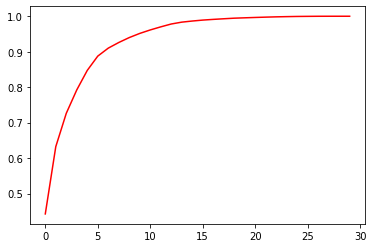

In [548]:
# Plot the cumulative variance explained by all the components
import matplotlib.pyplot as plt
cumvals = np.cumsum(vals)
plt.plot(ind, cumvals, c='r')

In [549]:
# Define scree plot function

def scree_plot(pca):

  plt.figure(figsize=(12,6))
  ax = plt.subplot(111)
  ax.grid(True)
  
  ax.xaxis.set_tick_params(width=0)
  ax.yaxis.set_tick_params(width=2, length=12)

  ax.set_xlabel("Principal Component")
  ax.set_ylabel("Variance Explained (%)")
  plt.title('Explained Variance Per Principal Component')

  ax.axhline(y=0.9, color='black', linewidth=1)

  ax.bar(ind, vals)
  ax.plot(ind, cumvals, c='r')



  plt.show()

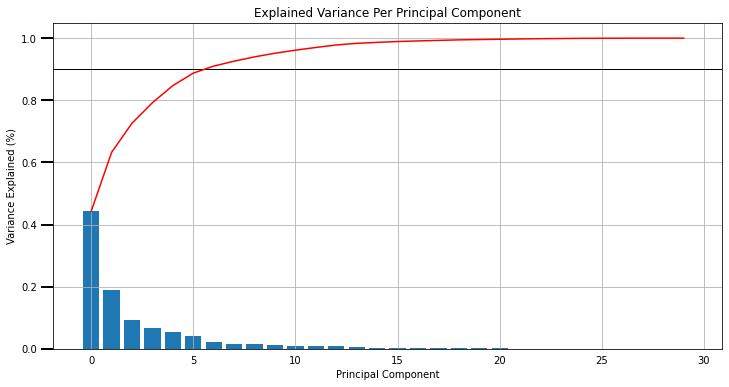

In [550]:
# Apply the plot function to our principle component
scree_plot(pca)

In [551]:
pca_features = pd.DataFrame(pca_features)

pca_features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,9.192837,1.948583,-1.123166,3.633731,-1.195110,1.411424,2.159370,-0.398407,-0.157118,-0.877402,0.262955,-0.859014,0.103388,-0.690804,-0.601793,0.745116,-0.265471,-0.549563,-0.133768,0.345565,0.096515,0.068850,0.084519,-0.175256,-0.151020,-0.201503,-0.252585,-0.033914,0.045648,-0.047169
1,2.387802,-3.768172,-0.529293,1.118264,0.621775,0.028656,0.013358,0.240988,-0.711905,1.106995,0.813120,0.157923,-0.943529,-0.653475,0.008975,-0.648809,-0.017212,0.318297,0.247565,-0.114133,-0.077327,-0.094578,-0.217718,0.011290,-0.170510,-0.041129,0.181270,0.032624,-0.005687,-0.001868
2,5.733896,-1.075174,-0.551748,0.912083,-0.177086,0.541452,-0.668166,0.097374,0.024066,0.454275,-0.605604,0.124387,-0.410627,0.016680,0.483420,0.325111,0.190918,-0.087975,0.392626,-0.204532,0.311067,-0.060309,-0.074291,0.102762,0.171158,0.004735,0.049569,0.047026,0.003146,0.000751
3,7.122953,10.275589,-3.232790,0.152547,-2.960878,3.053422,1.429911,1.059565,-1.405440,-1.116975,-1.151514,1.011316,-0.933271,-0.487417,-0.168848,0.051370,0.482634,-0.035875,0.026748,-0.464734,0.434193,-0.203266,-0.124105,0.153430,0.077496,-0.275225,0.183462,0.042484,-0.069295,-0.019937
4,3.935302,-1.948072,1.389767,2.940639,0.546747,-1.226495,-0.936213,0.636376,-0.263805,0.377704,0.651360,-0.110515,0.387948,-0.539181,0.310319,-0.152606,0.133142,-0.018714,-0.461436,0.065495,-0.116545,-0.017650,0.139454,-0.005332,0.003062,0.039254,0.032168,-0.034786,0.005038,0.021214


In [552]:
headers = []

for i in range(1,31):
  headers.append("PC" + str(i))

pca_features.columns = headers

pca_features.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30
0,9.192837,1.948583,-1.123166,3.633731,-1.195110,1.411424,2.159370,-0.398407,-0.157118,-0.877402,0.262955,-0.859014,0.103388,-0.690804,-0.601793,0.745116,-0.265471,-0.549563,-0.133768,0.345565,0.096515,0.068850,0.084519,-0.175256,-0.151020,-0.201503,-0.252585,-0.033914,0.045648,-0.047169
1,2.387802,-3.768172,-0.529293,1.118264,0.621775,0.028656,0.013358,0.240988,-0.711905,1.106995,0.813120,0.157923,-0.943529,-0.653475,0.008975,-0.648809,-0.017212,0.318297,0.247565,-0.114133,-0.077327,-0.094578,-0.217718,0.011290,-0.170510,-0.041129,0.181270,0.032624,-0.005687,-0.001868
2,5.733896,-1.075174,-0.551748,0.912083,-0.177086,0.541452,-0.668166,0.097374,0.024066,0.454275,-0.605604,0.124387,-0.410627,0.016680,0.483420,0.325111,0.190918,-0.087975,0.392626,-0.204532,0.311067,-0.060309,-0.074291,0.102762,0.171158,0.004735,0.049569,0.047026,0.003146,0.000751
3,7.122953,10.275589,-3.232790,0.152547,-2.960878,3.053422,1.429911,1.059565,-1.405440,-1.116975,-1.151514,1.011316,-0.933271,-0.487417,-0.168848,0.051370,0.482634,-0.035875,0.026748,-0.464734,0.434193,-0.203266,-0.124105,0.153430,0.077496,-0.275225,0.183462,0.042484,-0.069295,-0.019937
4,3.935302,-1.948072,1.389767,2.940639,0.546747,-1.226495,-0.936213,0.636376,-0.263805,0.377704,0.651360,-0.110515,0.387948,-0.539181,0.310319,-0.152606,0.133142,-0.018714,-0.461436,0.065495,-0.116545,-0.017650,0.139454,-0.005332,0.003062,0.039254,0.032168,-0.034786,0.005038,0.021214


In [553]:
pc_1_and_2 = pca_features[["PC1", "PC2"]]

In [554]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(pc_1_and_2)

labels = kmeans.labels_

print(labels)


[1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 1 1 0 0 1 0 1 0 1 0
 0 1 0 1 1 0 0 1 1 1 0 1 0 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0
 0 1 0 0 0 0 1 1 0 0 1 1 0 0 0 0 1 1 1 0 1 1 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0
 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 1 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 1 1 0 0 0
 0 0 0 0 0 1 0 0 1 1 0 1 1 1 1 0 1 1 1 0 0 0 0 0 0 1 0 1 1 1 1 0 0 1 1 0 0
 0 1 0 0 0 0 0 1 1 0 0 1 0 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 1 0 1 1 1 0 1 1 1
 1 1 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 1 1 1 0 0
 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1
 1 0 1 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0
 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 1 0 1 0 0 0 0 1 

In [555]:
pca_features['clusters_with_2_PC'] = labels
pca_features.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,clusters_with_2_PC
0,9.192837,1.948583,-1.123166,3.633731,-1.195110,1.411424,2.159370,-0.398407,-0.157118,-0.877402,0.262955,-0.859014,0.103388,-0.690804,-0.601793,0.745116,-0.265471,-0.549563,-0.133768,0.345565,0.096515,0.068850,0.084519,-0.175256,-0.151020,-0.201503,-0.252585,-0.033914,0.045648,-0.047169,1
1,2.387802,-3.768172,-0.529293,1.118264,0.621775,0.028656,0.013358,0.240988,-0.711905,1.106995,0.813120,0.157923,-0.943529,-0.653475,0.008975,-0.648809,-0.017212,0.318297,0.247565,-0.114133,-0.077327,-0.094578,-0.217718,0.011290,-0.170510,-0.041129,0.181270,0.032624,-0.005687,-0.001868,1
2,5.733896,-1.075174,-0.551748,0.912083,-0.177086,0.541452,-0.668166,0.097374,0.024066,0.454275,-0.605604,0.124387,-0.410627,0.016680,0.483420,0.325111,0.190918,-0.087975,0.392626,-0.204532,0.311067,-0.060309,-0.074291,0.102762,0.171158,0.004735,0.049569,0.047026,0.003146,0.000751,1
3,7.122953,10.275589,-3.232790,0.152547,-2.960878,3.053422,1.429911,1.059565,-1.405440,-1.116975,-1.151514,1.011316,-0.933271,-0.487417,-0.168848,0.051370,0.482634,-0.035875,0.026748,-0.464734,0.434193,-0.203266,-0.124105,0.153430,0.077496,-0.275225,0.183462,0.042484,-0.069295,-0.019937,1
4,3.935302,-1.948072,1.389767,2.940639,0.546747,-1.226495,-0.936213,0.636376,-0.263805,0.377704,0.651360,-0.110515,0.387948,-0.539181,0.310319,-0.152606,0.133142,-0.018714,-0.461436,0.065495,-0.116545,-0.017650,0.139454,-0.005332,0.003062,0.039254,0.032168,-0.034786,0.005038,0.021214,1


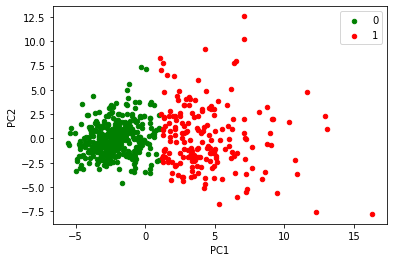

In [557]:

fig, ax = plt.subplots()
colors = {0 : "green", 1 : "red"}
grouped = pca_features.groupby("clusters_with_2_PC")
for key, group in grouped:
  group.plot(ax = ax, kind = "scatter", x = 0, y = 1, label = key, color = colors[key])
plt.show()

In [558]:
test_PC12 = (df_diagnosis_test["diagnosis"] == pca_features["clusters_with_2_PC"])
test_PC12

0      True
1      True
2      True
3      True
4      True
       ... 
564    True
565    True
566    True
567    True
568    True
Length: 569, dtype: bool

In [559]:
((test_PC12 == True).sum() / test_PC12.value_counts().sum()) * 100

90.68541300527241

In [ ]:
# 90.7% accuracy when using 2 principal components

In [560]:
pc_first_7 = pca_features[["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7"]]
k = KMeans(n_clusters=2)
k.fit(pc_first_7)
labels = k.labels_

print(labels)

[1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 1 1 0 0 1 0 1 0 1 0
 0 1 0 1 1 0 0 1 1 1 0 1 0 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0
 0 1 0 0 0 0 1 1 0 0 1 1 0 0 0 0 1 1 1 0 1 1 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0
 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 1 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0
 0 0 0 0 0 1 0 0 1 1 0 1 1 1 1 0 1 1 1 0 0 0 0 0 0 1 0 1 1 1 1 0 0 1 1 0 0
 0 1 0 0 0 0 0 1 1 0 0 1 0 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 1 0 1 1 1 0 1 1 1
 1 1 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 1 1 1 0 0
 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1
 1 0 1 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0
 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 1 0 1 0 0 0 0 1 

In [561]:
pca_features['clusters_with_7_PC'] = labels
pca_features.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,clusters_with_2_PC,clusters_with_7_PC
0,9.192837,1.948583,-1.123166,3.633731,-1.195110,1.411424,2.159370,-0.398407,-0.157118,-0.877402,0.262955,-0.859014,0.103388,-0.690804,-0.601793,0.745116,-0.265471,-0.549563,-0.133768,0.345565,0.096515,0.068850,0.084519,-0.175256,-0.151020,-0.201503,-0.252585,-0.033914,0.045648,-0.047169,1,1
1,2.387802,-3.768172,-0.529293,1.118264,0.621775,0.028656,0.013358,0.240988,-0.711905,1.106995,0.813120,0.157923,-0.943529,-0.653475,0.008975,-0.648809,-0.017212,0.318297,0.247565,-0.114133,-0.077327,-0.094578,-0.217718,0.011290,-0.170510,-0.041129,0.181270,0.032624,-0.005687,-0.001868,1,1
2,5.733896,-1.075174,-0.551748,0.912083,-0.177086,0.541452,-0.668166,0.097374,0.024066,0.454275,-0.605604,0.124387,-0.410627,0.016680,0.483420,0.325111,0.190918,-0.087975,0.392626,-0.204532,0.311067,-0.060309,-0.074291,0.102762,0.171158,0.004735,0.049569,0.047026,0.003146,0.000751,1,1
3,7.122953,10.275589,-3.232790,0.152547,-2.960878,3.053422,1.429911,1.059565,-1.405440,-1.116975,-1.151514,1.011316,-0.933271,-0.487417,-0.168848,0.051370,0.482634,-0.035875,0.026748,-0.464734,0.434193,-0.203266,-0.124105,0.153430,0.077496,-0.275225,0.183462,0.042484,-0.069295,-0.019937,1,1
4,3.935302,-1.948072,1.389767,2.940639,0.546747,-1.226495,-0.936213,0.636376,-0.263805,0.377704,0.651360,-0.110515,0.387948,-0.539181,0.310319,-0.152606,0.133142,-0.018714,-0.461436,0.065495,-0.116545,-0.017650,0.139454,-0.005332,0.003062,0.039254,0.032168,-0.034786,0.005038,0.021214,1,1


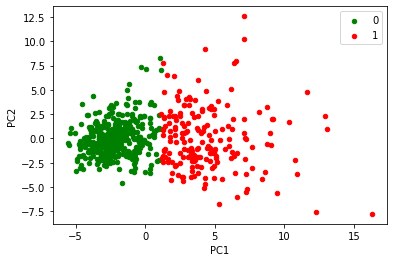

In [563]:
fig, ax = plt.subplots()
colors = {0 : "green", 1 : "red"}
grouped = pca_features.groupby("clusters_with_7_PC")
for key, group in grouped:
  group.plot(ax = ax, kind = "scatter", x = 0, y = 1, label = key, color = colors[key])
plt.show()

In [564]:
test_PC12 = (df_diagnosis_test["diagnosis"] == pca_features["clusters_with_7_PC"])
test_PC12

0      True
1      True
2      True
3      True
4      True
       ... 
564    True
565    True
566    True
567    True
568    True
Length: 569, dtype: bool

In [565]:
((test_PC12 == True).sum() / test_PC12.value_counts().sum()) * 100

91.03690685413005

In [ ]:
# 91% accuracy when using 7 principal components

## Check your work: 

- Compare your PC1, PC2 clustering scatterplot to the clustering scatterplots you made on the raw data
- Calculate accuracy scores for both the PC1,PC2 Principal component clustering and the 90% of explained variance clustering.

How do your accuracy scores -when preprocessing the data with PCA- compare to the accuracy when simply clustering on the raw data?

In [ ]:
# My accuracy scores improved from raw data, to PC1/PC2, to using 7 PCs.

# Stretch Goals:

- Study for the Sprint Challenge
- Work on your Data Storytelling Project